# Training AE

This notebook shows how to train the anomaly detection model.

In [85]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import optuna

from models import SpatioTemporalAutoencoder
from parameters import STAEParameters, TrainingParameters
from datautils import get_morning_data
from training import save_model, load_model, train_stae, compute_anomaly_threshold, test_model, threshold_anomalies, fill_result_df
import torch.nn as nn
from tqdm import tqdm

import random
import os

In [86]:
mse_weights = [1,4,1] # weights for loss function (occupancy, speed, volume)

In [87]:
training_params = TrainingParameters(
    learning_rate=1e-4,
    batch_size=1,
    timesteps=20,
    n_epochs=3
)

In [88]:
training_data = get_morning_data(1, timesteps=training_params.timesteps) # train on day 1, free of crashes

In [89]:
hyperparams = STAEParameters(
    num_features=training_data[0][0].num_features,
    latent_dim=32,
    gcn_hidden_dim=64,
    lstm_hidden_dim=64,
    lstm_num_layers=2,
    dropout=0.2
)

In [90]:
ae = SpatioTemporalAutoencoder(hyperparams)

In [91]:
ae(training_data[0]).shape

torch.Size([196, 3])

In [92]:
ae, losses = train_stae(staeparams=hyperparams, trainingparams=training_params, training_data=training_data, mse_weights=mse_weights, verbose=True)

 33%|███▎      | 1/3 [01:05<02:10, 65.39s/it]

Epoch number 0 last 100 loss 0.03920108014717698


 67%|██████▋   | 2/3 [02:06<01:03, 63.10s/it]

Epoch number 1 last 100 loss 0.01802678716368973


100%|██████████| 3/3 [03:05<00:00, 61.67s/it]

Epoch number 2 last 100 loss 0.017363158906809985


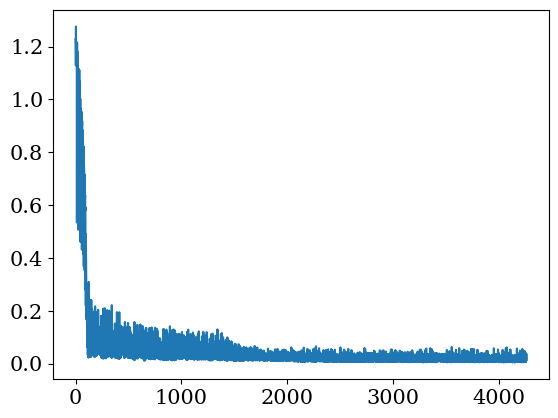

In [93]:
plt.plot(losses)

In [94]:
use_pretrained = False
if use_pretrained:
    study_name = 'gcn_ae_w4'  # Replace with your study name
    storage_subdirectory = 'studies'
    storage_url = f'sqlite:///{os.path.join(storage_subdirectory, study_name)}.db'
    study = optuna.load_study(study_name='gcn_ae_w4', storage=storage_url)

    # Get the best hyperparameters
    # best_params = study.best_params
    best_params = study.trials[56].params
    print(best_params)
    mse_weights = [1,4,1]

    training_data = get_morning_data(1, best_params['timesteps'])
    ae_params = STAEParameters(
        num_features=training_data[0][0].num_features,
        latent_dim=best_params['latent_dim'],
        gcn_hidden_dim=best_params['gcn_hidden_dim'],
        lstm_hidden_dim=best_params['lstm_hidden_dim'],
        lstm_num_layers=best_params['lstm_num_layers'],
        dropout=best_params['dropout'] # should not need this
    )

    ae = load_model(SpatioTemporalAutoencoder, ae_params, 'opt_57')

    test_data = get_morning_data(4, timesteps=best_params['timesteps'])

In [95]:
thresh = compute_anomaly_threshold(training_data, ae, mse_weights, 'max')

100%|██████████| 1421/1421 [00:35<00:00, 39.74it/s]


In [96]:
if not use_pretrained:
    test_data = get_morning_data(4, timesteps=training_params.timesteps)

In [97]:
test_errors, test_recons_speeds, test_true_speeds = test_model(test_data, mse_weights, ae)

In [98]:
np.mean(test_errors)

0.02982886

In [99]:
anomalies = threshold_anomalies(thresh, test_errors)

In [100]:
df = fill_result_df(anomalies, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [101]:
df.to_csv('./saved_results/day4_results_test.csv')

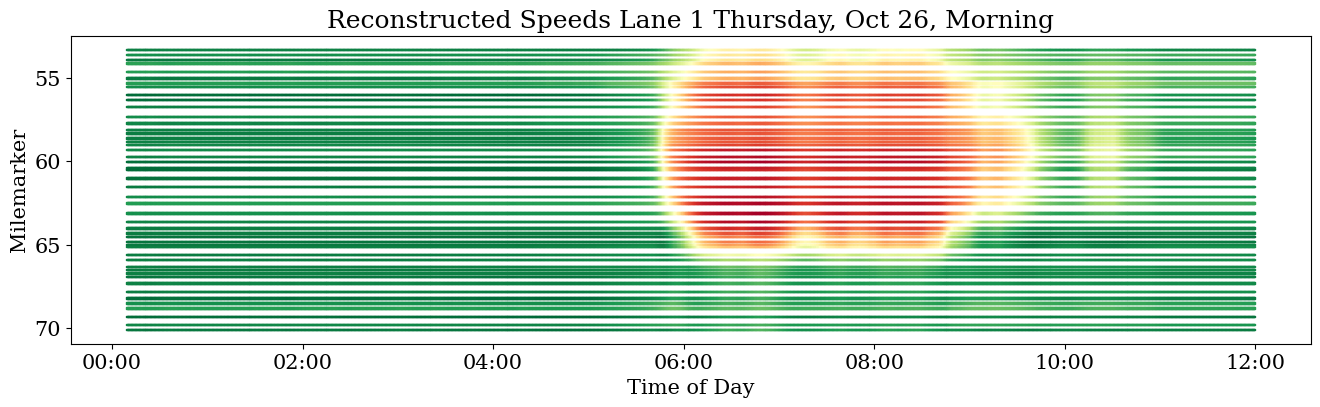

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/day4_results_test.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index'] * 30, unit='s')
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

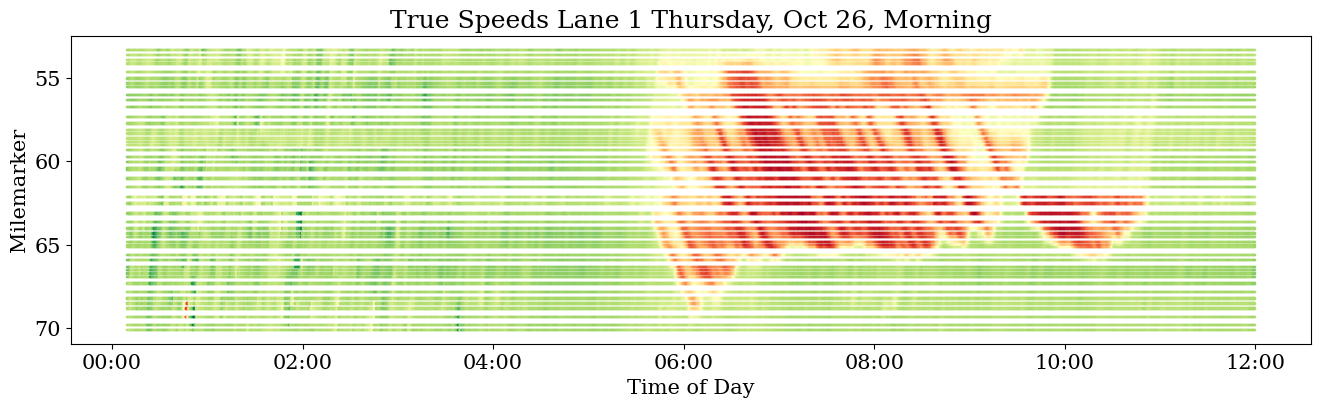

In [103]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 09:30:00')
end_time = pd.to_datetime('1970-01-01 09:50:00')
# plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Thursday, Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

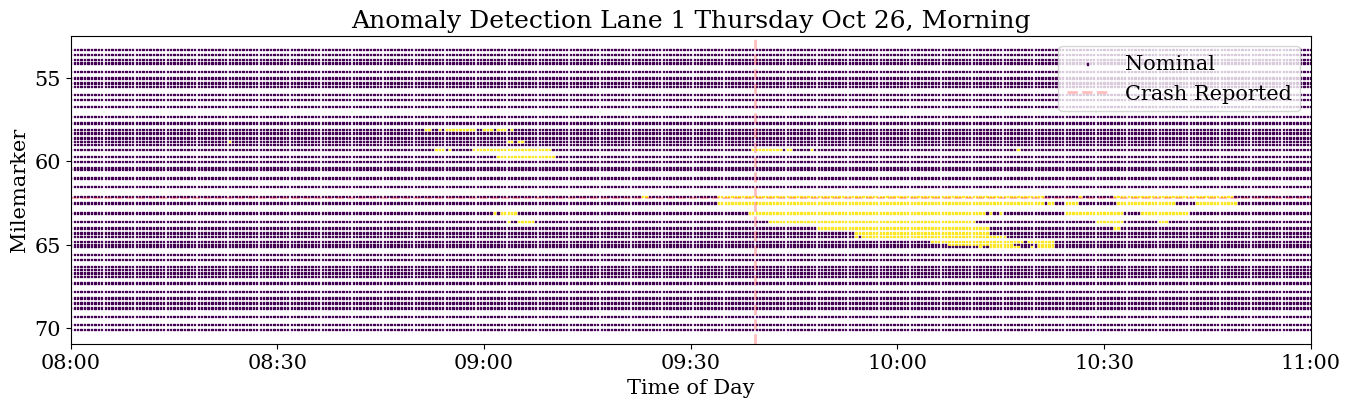

In [104]:
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 08:00:00')
end_time = pd.to_datetime('1970-01-01 11:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=vline_time, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)
plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Thursday Oct 26, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()